RMIT University in Vietnam

**Course**: COSC2753 Machine Learning

**Semester**: 2021A

**Assessment**: Machine Learning Project

**Authors**: Le Nguyen Minh Huy - s3777280 + Nguyen Manh Triet - s3678932 

**Date created**: 7/5/2021

**Last updated**: 24/5/2021


#Introduction

Adverse Drug Reaction (ADR), as depicted from its definition, is a noxious and unintended response of a drug that occurs at normal prescribed doses used in humans for various medical purposes like diagnosis, therapy of disease and so on. Seminar research undertaken in the late 20th and early 21st century in the USA and the UK indicated that the incidence of ADRs has remained relatively unchanged overtime. For elaboration, such figures suggest that an approximate of 5% and 10% of patients may suffer from an ADR at admission, during admission or at discharge, despite various precautionary efforts. Moreover, this prevalence threat needs to be thoroughly studied due to its correlation with morbidity and mortality, which can be financially costly and pose a potential negative impact on the prescriber-patient relationship.

By implementing information extraction technologies, our project aims to classify a particular contextual content and determine whether it is related to Adverse Drug Reaction or not. Specifically, we will construct a deep learning model to perform binary classification. The input for this model will be a chunk of text and the expected outcome should be a binary indicator 0 or 1, in which 1 indicates having adverse drug reaction, while 0 is the opposite. Additionally, the sequences which are classified 1 from the previous model will be hence transferred to the information extraction model, which is a Named Entity Recognition model.

# Text classification model

## Library

In [ ]:
!pip install datasets

In [ ]:
!pip install BackTranslation

In [ ]:
# for working with dataset
import logging
import pandas as pd
import numpy as np
from numpy import random
from datasets import ClassLabel
from IPython.display import display, HTML

# oversampling data
from BackTranslation import BackTranslation

# for visualizing data 
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
import matplotlib.pyplot as plt

# for modelling
import gensim
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, plot_roc_curve
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Bidirectional, TimeDistributed, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping




## EDA

The datasets implemented in this model is extracted from the Dataset Card for Adverse Drug Reaction Data v2 via *Hugging Face’s dataset* API. This model uses the ***Ade_corpus_v2_classification*** instance, which is used to classify whether a sentence is ADE-related (True) or not (False), containing 33709 rows and 2 attributes.

In [ ]:
from datasets import load_dataset
dataset_cf = load_dataset('ade_corpus_v2', 'Ade_corpus_v2_classification')

In [ ]:
df_cf = pd.DataFrame(dataset_cf['train'])

In [ ]:
display(HTML(df_cf[:10].to_html()))

,label,text
0,1,Intravenous azithromycin-induced ototoxicity.
1,1,"Immobilization, while Paget's bone disease was present, and perhaps enhanced activation of dihydrotachysterol by rifampicin, could have led to increased calcium-release into the circulation."
2,1,Unaccountable severe hypercalcemia in a patient treated for hypoparathyroidism with dihydrotachysterol.
3,1,METHODS: We report two cases of pseudoporphyria caused by naproxen and oxaprozin.
4,1,METHODS: We report two cases of pseudoporphyria caused by naproxen and oxaprozin.
5,1,"Naproxen, the most common offender, has been associated with a dimorphic clinical pattern: a PCT-like presentation and one simulating erythropoietic protoporphyria in the pediatric population."
6,1,RESULTS: A 44-year-old man taking naproxen for chronic low back pain and a 20-year-old woman on oxaprozin for rheumatoid arthritis presented with tense bullae and cutaneous fragility on the face and the back of the hands.
7,1,RESULTS: A 44-year-old man taking naproxen for chronic low back pain and a 20-year-old woman on oxaprozin for rheumatoid arthritis presented with tense bullae and cutaneous fragility on the face and the back of the hands.
8,1,RESULTS: A 44-year-old man taking naproxen for chronic low back pain and a 20-year-old woman on oxaprozin for rheumatoid arthritis presented with tense bullae and cutaneous fragility on the face and the back of the hands.
9,1,RESULTS: A 44-year-old man taking naproxen for chronic low back pain and a 20-year-old woman on oxaprozin for rheumatoid arthritis presented with tense bullae and cutaneous fragility on the face and the back of the hands.


In [ ]:
df_cf = df_cf.drop_duplicates().reset_index(drop = True)

In [ ]:
# visualize the distribution of target column (LengthOfStay)
target_df = pd.DataFrame(df_cf['label'].value_counts()).rename(columns = {'label': 'Total value'},
                              index = {0: 'Not-Related', 
                                       1: 'Related'}
                              )
target_df['Percentage'] = round(target_df['Total value']/len(df_cf) * 100, 2)

fig = go.Figure(data = [go.Bar (
    x=target_df.index.tolist(),
    y = target_df['Percentage'].tolist(),
    width=[0.4, 0.4],
    marker_color = ["#f5cb42", '#de9b8c'])
])

fig.update_layout(
    title_text = "Percentage of medical context whether adverse drug related or not", 
    xaxis_title = 'Class', 
    yaxis_title = 'Percentage')


Training a model in an imbalanced dataset leads to a significant bias towards larger classes. Moreover, the class with fewer data points will be treated as noise and ignored during the training process. There are two main ways to balancing the datasets: oversampling and undersampling. 

As we lose much information using the undersampling method, the team implemented oversampling technique which helps them to have more data of the minority class. In NLP, the **back-translation** technique allows us to paraphrase each instance in the dataset. Specifically, we did translate the original corpus from English to three common languages that are* French*, *Japanese*, and *Spanish*, and then back translating them to English. To implement the technique, we have used the `BackTranslation` python package which utilizes the googletrans library and Baidu Translation API.

## Handle imbalanced data

Dealing with an **imbalanced dataset** is one of the most crucial phases to have a model with good performance. There are lots of strategies to handle the problem which could be improving the classification algorithms or balancing the dataset. Regarding balancing the training dataset, as we will lose much information if undersampling, the team decided to implement oversampling technique which helps us to have more data of the minority class.

In Natural Language Processing (NLP), the **back-translation** technique allows us to paraphrase each instance in the dataset. Specifically, we will translate the original corpus from English to different common languages that are *French*, *Japanese*, and *Spanish*, and then back translating them  to English [ref]. To implement the technique, we have used the BackTranslation python package which utilizes the `googletrans` library and `Baidu Translation` API.

In [ ]:
trans = BackTranslation(url=[
      'translate.google.com',
      'translate.google.co.kr',
    ])

language_code =  ['fr','es', 'ja']

In [ ]:
text_bt = []
for language in language_code:
  for i in range (0, len(df_cf[df_cf['label'] == 1])):
    trans = BackTranslation(url=[
        'translate.google.com',
        'translate.google.co.kr',
      ])
    text_translate = trans.translate(df_cf['text'][i],
                                src ='en',
                                tmp = language)
                    
    result = text_translate.result_text
    text_bt.append(result)

In [ ]:
labels = []
for _ in range (0,3):
  for i in range(0, len(df_cf[df_cf['label'] ==1])):
    labels.append(1)

In [ ]:
df_cf_bt = pd.DataFrame(data = {'label': labels, 'text': text_bt})

In [ ]:
df_cf = df_cf.append(df_cf_bt, ignore_index=True)

In [ ]:
df_cf

,label,text
0,1,Intravenous azithromycin-induced ototoxicity.
1,1,"Immobilization, while Paget's bone disease was..."
2,1,Unaccountable severe hypercalcemia in a patien...
3,1,METHODS: We report two cases of pseudoporphyri...
4,1,"Naproxen, the most common offender, has been a..."
...,...,...
33704,1,Reversible Non-pleureline declining palatable ...
33705,1,Lithium treatment ended in 1975 for lithium po...
33706,1,Eosinophilic caused by clozapine was observed ...
33707,1,Eyeosinospheric spheres encountered 0.2 to 61....


In [ ]:
my_data = df_cf.to_csv('balanced_data')

## Load balanced dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_cf = pd.read_csv('/content/drive/MyDrive/balanced_data', index_col =0)

In [ ]:
# visualize the distribution of target column (LengthOfStay)
target_df = pd.DataFrame(df_cf['label'].value_counts()).rename(columns = {'label': 'Total value'},
                              index = {0: 'Not-Related', 
                                       1: 'Related'}
                              )
target_df['Percentage'] = round(target_df['Total value']/len(df_cf) * 100, 2)

fig = go.Figure(data = [go.Bar (
    x=target_df.index.tolist(),
    y = target_df['Percentage'].tolist(),
    width=[0.4, 0.4],
    marker_color = ["#f5cb42", '#de9b8c'])
])

fig.update_layout(
    title_text = "Percentage of medical context whether adverse drug related or not", 
    xaxis_title = 'Class', 
    yaxis_title = 'Percentage')


In [ ]:
df_cf['length'] = df_cf['text'].str.split().str.len()

In [ ]:
df_cf = df_cf.drop_duplicates().reset_index(drop = True)

In [ ]:
print("Median length: ",np.median(df_cf['length']))
print("Mean length: ",round(np.mean(df_cf['length']),2))
print("Max length: ", np.max(df_cf['length']))

Median length:  17.0
Mean length:  18.17
Max length:  135


## Machine Learning approach

### Feature extraction 

As Machine Learning algorithms can only deal with numerical data, text data needs to be converted to numbers. One of the most common ways to perform machine learning on text is representing documents in vectors, whose process is called vectorization [ref ]. Technically, there are lots of effective ways to generate text to numbers, such as label encoding, one-hot encoding, etc. However, the meaning and the relationship between words may be ignored during the training process by using these techniques since the vectors are simply discrete numbers. Thus, to deal with the issue, the team decided to use TFIDFVectorizer which enables us to emphasize the importance of words in specific documents and their relevance in other documents as well.

TFIDF stands for Term Frequency - Inverse Document Frequencies, which not only aims to indicate the importance of the words in the given context but also take into account the relation to other documents from the same corpus. The algorithm is focusing on the number of times that word appears in a document and in other documents in the corpus as well. To be more specific, a word that often appears in a document has more relevance for that document, which interprets there is a higher probability that the document is about that specific word. Moreover, when a word frequently appears in lots of different documents, it would be considered as a less-important word since it is relevant for many documents from the whole set.

In [ ]:
vectorizer = TfidfVectorizer()                                                                            

In [ ]:
# independent and dependent variable
X = df_cf['text']
y = df_cf['label']

# spit dataset into three sets: training set, validation set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state = 123) 

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size = 0.2,
                                                  random_state = 123)

In [ ]:
X_train_tfidf = vectorizer.fit_transform(X_train.values)

In [ ]:
X_train_tfidf.shape

(21573, 19602)

In [ ]:
feature_names = vectorizer.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=X_train_tfidf[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), 
                  index=feature_names, 
                  columns=["tfidf_score"]) 
df.sort_values(by=["tfidf_score"],ascending=False).head(20)

,tfidf_score
pterygium,0.395878
02,0.347663
excision,0.333936
intraoperative,0.295709
28,0.279632
application,0.277799
minutes,0.277799
mitomycin,0.275203
underwent,0.246094
single,0.234924


When applying `fit_transform` to the training set, the vectorizer object has fixed the vocabulary containing in that corpus. Hence, with the validation set, we should only use `transform` function instead of utilizing the `fit_transform` as this would update our vocabulary set.

In [ ]:
X_val_tfidf = vectorizer.transform(X_val.values)

### Modeling

. To evaluate the model on the validation set, the team chose the metrics of F1 score, a harmonic means of precision and recall. Since F1 score conveys the balance between precision and recall, it is preferable to use in some classification problem.

#### 1) MultinomialNB 

**MultinomialNB** stands for Multinomial Naive Bayes algorithm which is a probabilistic learning method often applied in Natural Language Processing (NLP). Based on the Bayes theorem, the algorithm returns the label of a given text. Specifically, it computes the probability of each label for a particular document and then choose the result of the *highest probability* as output.


In [ ]:
clf_1 = MultinomialNB()
clf_1.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
y_pred = clf_1.predict(X_val_tfidf)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.80      0.84      2612
           1       0.83      0.89      0.86      2782

    accuracy                           0.85      5394
   macro avg       0.85      0.85      0.85      5394
weighted avg       0.85      0.85      0.85      5394



In [ ]:
f1 = f1_score(y_val,y_pred)
auc_score = roc_auc_score(y_val, y_pred)


print(f'F1 score: {round(100*f1,2)}')

F1 score: 85.73


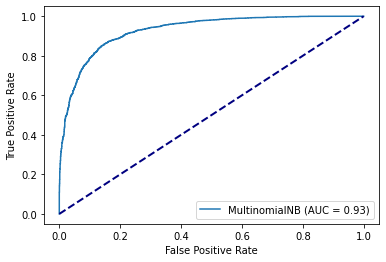

In [ ]:
# visualize the result 
plot_roc_curve(clf_1, X_val_tfidf, y_val) 
plt.plot([0, 1], [0, 1], color='navy', lw= 2, linestyle='--')
plt.show()   

#### 2) LightGBM 


**LightGBM** is a gradient boosting which is currenly mostly use in classification task. Regarding tree based learning algorithm, LightGBM model grows tree vertically instead of horizontally like others, which is called tree leaf-wise. By using this algorithm, we did reduce significant loss than other level-wise algorithm as well as choose a max-delta-loss leaf to grow.

Moreover, LightGBM algorithm can work fast with a large amount of data and takes lower memory to execute.

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
clf_2 = LGBMClassifier()
clf_2.fit(X_train_tfidf, y_train)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
y_pred = clf_2.predict(X_val_tfidf)

In [ ]:
f1 = f1_score(y_val, y_pred)
print(f'F1 score: {round(100*f1,2)}')

F1 score: 82.84


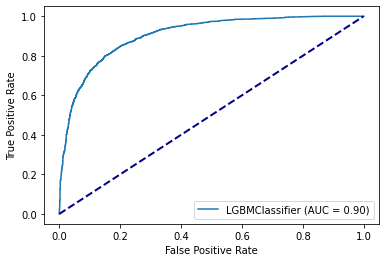

In [ ]:
# visualize the result 
plot_roc_curve(clf_2, X_val_tfidf, y_val) 
plt.plot([0, 1], [0, 1], color='navy', lw= 2, linestyle='--')
plt.show()   

#### 3) Logistic Regression

Logistic regression uses the logistic function as known as the sigmoid function. Logistic regression can not only predict the discrete label but also predict the probabilities of for each class based on given attributes.

The sigmoid function is an S-shaped curve that can take any real number and map it into a value between 0 and 1.

In [ ]:
from sklearn.linear_model import LogisticRegression
clf_3 = LogisticRegression()
clf_3.fit(X_train_tfidf, y_train)
y_pred = clf_3.predict(X_val_tfidf)

print(f'F1 score: {f1_score(y_val, y_pred)}')

F1 score: 0.8671804982971858


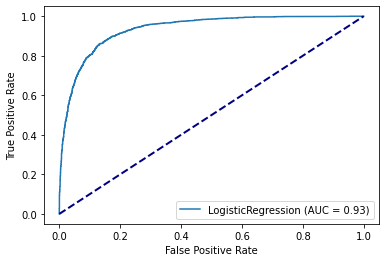

In [ ]:
# visualize the result 
plot_roc_curve(clf_3, X_val_tfidf, y_val) 
plt.plot([0, 1], [0, 1], color='navy', lw= 2, linestyle='--')
plt.show()   

## Deep Learning approach

#### Data Preporcessing

Long Short-Term Memory (LSTM) which belongs to a larger category of neural networks named Recurrent Neural Network (RNN) is widely used for many NLP tasks. As the model is able to handle the long term dependencies through its complicated architecture, LSTM returns a better performance when the context is quite long. Moreover, LSTM reduces the vanishing gradient problem happening with RNN model. Therefore, the team has built a bidirectional LSTM model for `text classification` task.



In [ ]:
# split dataset
X = df_cf['text']
y = df_cf['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)


After splitting the dataset into 3 segments, which are: training set, validation set and test set, the data will be converted into numbers by implementing tokenize technique.

One of the most popular framework widely used in NLP, Keras, provides the Tokenizer function for data scientist to generate text document to numbers. Then, the output will be fitted to the CNN model.


In [ ]:
max_words = 5000
max_len = max(df_cf['length'])
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

sequences = tokenizer.texts_to_sequences(X_train)

sequences_matrix = sequence.pad_sequences(sequences,
                                          maxlen=max_len)

### RNN: Long-Short Term Memory

We constructed the RNNModel function that allows us to build and add more layers. Inside the function, there is an Embedding layer to embed text to numerical data. The following layer is LSTM with the vectors' size of 64. Then, pass those vectors through the fully connected linear layer Dense with the `relu` activation function. Finally, using sigmoid function to get the probability of the sequences belonging to Adversed Drug Event (class 1).


In [ ]:
def train_model(model):
  model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate = 0.001),
              metrics=[keras.metrics.Precision(),
                        keras.metrics.Recall()]
              )
  model.fit(sequences_matrix,
          y_train,
          batch_size=128,
          epochs= 5,
          validation_split = 0.2,
          callbacks=[EarlyStopping(monitor='val_loss',
                                   min_delta=0.001
                                   )])

def eval_model(model):
  # process validate data

  val_sequences = tokenizer.texts_to_sequences(X_val)
  val_sequences_matrix = sequence.pad_sequences(val_sequences,
                                                maxlen=max_len)
  
  result = model.evaluate(val_sequences_matrix,
                        y_val)
  print('Precision', result[1])
  print('Recall', result[2])
  print('F1 score', 2*result[1]*result[2]/(result[1] + result[2]))


#### 1) Baseline 

This model has only one LSTM layer and two activation functions: **ReLU** and **sigmoid**.

In [ ]:
def LSTMbaseline():
  activation_func = 'relu'
  inputs = Input(name='inputs',shape=[max_len])
  layer = Embedding(input_dim=max_words, 
                    output_dim=12,
                    input_length=max_len)(inputs)
  layer = LSTM(128, activation=activation_func)(layer)
  layer = Dense(1,name='out_layer')(layer)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs=inputs,outputs=layer)
  return model

model = LSTMbaseline()
model.summary()


Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 135)]             0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 135, 12)           60000     
_________________________________________________________________
lstm_23 (LSTM)               (None, 128)               72192     
_________________________________________________________________
out_layer (Dense)            (None, 1)                 129       
_________________________________________________________________
activation_28 (Activation)   (None, 1)                 0         
Total params: 132,321
Trainable params: 132,321
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train_model(model)

In [ ]:
eval_result = eval_model(model)

167/167 [==============================] - 6s 39ms/step - loss: 0.6513 - precision_12: 0.6715 - recall_12: 0.9223
Precision 0.6714712977409363
Recall 0.9223010540008545
F1 score 0.7771482357075303


#### 2) One LSTM layer and dropout layer

For addressing overfitting issue, a regularization technique - dropout wasapplied to the one-LSTM-layer model. We have chosen the dropout rate of 0.5.

In [ ]:
def onelayer_dropout():
  activation_func = 'relu'
  dropout_rate = 0.5
  inputs = Input(name='inputs',shape=[max_len])
  layer = Embedding(input_dim=max_words, 
                    output_dim=12,
                    input_length=max_len)(inputs)

  layer = LSTM(128, activation=activation_func)(layer)
  layer = Dense(1,name='out_layer')(layer)
  layer = Dropout(dropout_rate)(layer)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs=inputs,outputs=layer)
  return model

model_2 = onelayer_dropout()
model_2.summary()



Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 135)]             0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 135, 12)           60000     
_________________________________________________________________
lstm_26 (LSTM)               (None, 128)               72192     
_________________________________________________________________
out_layer (Dense)            (None, 1)                 129       
_________________________________________________________________
dropout_11 (Dropout)         (None, 1)                 0         
_________________________________________________________________
activation_32 (Activation)   (None, 1)                 0         
Total params: 132,321
Trainable params: 132,321
Non-trainable params: 0
____________________________________________________

In [ ]:
history = train_model(model_2)

Epoch 1/5
134/134 [==============================] - 53s 385ms/step - loss: 0.6809 - precision_15: 0.6240 - recall_15: 0.2071 - val_loss: 0.5398 - val_precision_15: 0.8074 - val_recall_15: 0.7212
Epoch 2/5
134/134 [==============================] - 50s 376ms/step - loss: 0.5561 - precision_15: 0.7999 - recall_15: 0.4200 - val_loss: 0.4707 - val_precision_15: 0.7694 - val_recall_15: 0.9178
Epoch 3/5
134/134 [==============================] - 51s 378ms/step - loss: 0.5142 - precision_15: 0.8597 - recall_15: 0.4314 - val_loss: 0.4139 - val_precision_15: 0.8292 - val_recall_15: 0.8648
Epoch 4/5
134/134 [==============================] - 51s 379ms/step - loss: 0.4831 - precision_15: 0.8885 - recall_15: 0.4558 - val_loss: 0.3778 - val_precision_15: 0.8624 - val_recall_15: 0.8294
Epoch 5/5
134/134 [==============================] - 51s 381ms/step - loss: 0.4673 - precision_15: 0.9052 - recall_15: 0.4634 - val_loss: 0.3947 - val_precision_15: 0.7895 - val_recall_15: 0.9343


In [ ]:
eval_result = eval_model(model_2)

167/167 [==============================] - 7s 40ms/step - loss: 0.3891 - precision_15: 0.7985 - recall_15: 0.9372
Precision 0.798535943031311
Recall 0.9372431635856628
F1 score 0.8623474618751444



Arguments
- monitor: Quantity to be monitored. In this case, we use `val_loss` to monitor our quantity. 

- min_delta: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.



#### 3) Two LSTM layers with dropout

The related work has proved that RNN model performance can improve thanks to the number of LSTM layers, in other words the depth. Hence, we decided to experiment with two LSTM layers with the same dropout rate which is 0.5.

In [ ]:
def twolayer_dropout():
  activation_func = 'relu'
  dropout_rate = 0.5
  inputs = Input(name='inputs',shape=[max_len])
  layer = Embedding(input_dim=max_words, 
                    output_dim=12,
                    input_length=max_len)(inputs)

  layer = LSTM(128, activation=activation_func, 
                 return_sequences=True)(layer)

  layer = LSTM(256, activation=activation_func, 
               return_sequences=False)(layer)

  # layer = Dense(256,name='FC1')(layer)
  # layer = Activation(activation_func)(layer)
  layer = Dense(1,name='out_layer')(layer)
  layer = Dropout(dropout_rate)(layer)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs=inputs,outputs=layer)
  return model

model_3 = twolayer_dropout()
model_3.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 135)]             0         
_________________________________________________________________
embedding_23 (Embedding)     (None, 135, 12)           60000     
_________________________________________________________________
lstm_29 (LSTM)               (None, 135, 128)          72192     
_________________________________________________________________
lstm_30 (LSTM)               (None, 256)               394240    
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
_________________________________________________________________
dropout_13 (Dropout)         (None, 1)                 0         
_________________________________________________________________
activation_34 (Activation)   (None, 1)                 0  

In [ ]:
history = train_model(model_3)

Epoch 1/5
134/134 [==============================] - 216s 2s/step - loss: 0.6871 - precision_16: 0.5218 - recall_16: 0.3472 - val_loss: 0.5402 - val_precision_16: 0.7974 - val_recall_16: 0.7514
Epoch 2/5
134/134 [==============================] - 216s 2s/step - loss: 0.5533 - precision_16: 0.8266 - recall_16: 0.4001 - val_loss: 0.4503 - val_precision_16: 0.8568 - val_recall_16: 0.7717
Epoch 3/5
134/134 [==============================] - 217s 2s/step - loss: 0.5026 - precision_16: 0.8707 - recall_16: 0.4261 - val_loss: 0.4082 - val_precision_16: 0.8388 - val_recall_16: 0.8511
Epoch 4/5
134/134 [==============================] - 214s 2s/step - loss: 0.4746 - precision_16: 0.8940 - recall_16: 0.4545 - val_loss: 0.3722 - val_precision_16: 0.8591 - val_recall_16: 0.8388
Epoch 5/5
134/134 [==============================] - 210s 2s/step - loss: 0.4595 - precision_16: 0.9054 - recall_16: 0.4595 - val_loss: 0.3667 - val_precision_16: 0.8304 - val_recall_16: 0.9074


In [ ]:
eval_result = eval_model(model_3)

167/167 [==============================] - 30s 180ms/step - loss: 0.3642 - precision_16: 0.8308 - recall_16: 0.9044
Precision 0.8308167457580566
Recall 0.9043705463409424
F1 score 0.8660346899630812


#### 4) Three LSTM layers with dropout


Inspired by the high performance of Google Translate tool using seven layers of LSTM, the team stacked their model with another LSTM layer as well as the dropout layer.

In [ ]:
def threelayer_dropout():
  activation_func = 'relu'
  dropout_rate = 0.5
  inputs = Input(name='inputs',shape=[max_len])
  layer = Embedding(input_dim=max_words, 
                    output_dim=12,
                    input_length=max_len)(inputs)

  layer = LSTM(128, activation=activation_func, 
                 return_sequences=True)(layer)

  layer = LSTM(256, activation=activation_func, 
               return_sequences=True)(layer)

  layer = LSTM(256, activation=activation_func, 
               return_sequences=False)(layer)

  layer = Dense(1,name='out_layer')(layer)
  layer = Dropout(dropout_rate)(layer)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs=inputs,outputs=layer)
  return model

model_4 = threelayer_dropout()
model_4.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 135)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 135, 12)           60000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 135, 128)          72192     
_________________________________________________________________
lstm_4 (LSTM)                (None, 135, 256)          394240    
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               525312    
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
_________________________________________________________________
dropout_1 (Dropout)          (None, 1)                 0   

In [ ]:
history = train_model(model_4)

Epoch 1/5
134/134 [==============================] - 366s 3s/step - loss: 0.6932 - precision_1: 0.4892 - recall_1: 0.1107 - val_loss: 0.6531 - val_precision_1: 0.7004 - val_recall_1: 0.7300
Epoch 2/5
134/134 [==============================] - 374s 3s/step - loss: 0.6083 - precision_1: 0.7592 - recall_1: 0.3501 - val_loss: 0.4523 - val_precision_1: 0.7961 - val_recall_1: 0.8912
Epoch 3/5
134/134 [==============================] - 359s 3s/step - loss: 0.5113 - precision_1: 0.8489 - recall_1: 0.4503 - val_loss: 0.3866 - val_precision_1: 0.8633 - val_recall_1: 0.8609
Epoch 4/5
134/134 [==============================] - 367s 3s/step - loss: 0.4890 - precision_1: 0.8721 - recall_1: 0.4432 - val_loss: 0.3446 - val_precision_1: 0.8503 - val_recall_1: 0.9100
Epoch 5/5
134/134 [==============================] - 361s 3s/step - loss: 0.4603 - precision_1: 0.9056 - recall_1: 0.4660 - val_loss: 0.3669 - val_precision_1: 0.8307 - val_recall_1: 0.9238


In [ ]:
eval_result = eval_model(model_4)

167/167 [==============================] - 52s 310ms/step - loss: 0.3889 - precision_1: 0.8066 - recall_1: 0.9085
Precision 0.806633472442627
Recall 0.908479630947113
F1 score 0.854532657824075


#### 5) BidirectionalLSTM

We replaced one LSTM layer with one Bidirectional LSTM (BLSTM) layer. Although BLSTM has double memory cells compared to the LSTM layer, the text data is processed in both directions, which helps the model capture the patterns that may be fail recognized in a unidirectional LSTM.


In [ ]:
def bidirectional_dropout():
  activation_func = 'relu'
  dropout_rate = 0.5
  inputs = Input(name='inputs',shape=[max_len])
  layer = Embedding(input_dim=max_words, 
                    output_dim=12,
                    input_length=max_len)(inputs)
  layer = Bidirectional(LSTM(128, return_sequences=True))(layer)
  layer = LSTM(64, return_sequences=False)(layer)
  layer = Dense(1,name='out_layer')(layer)
  layer = Dropout(dropout_rate)(layer)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs=inputs,outputs=layer)
  return model

model_5 = bidirectional_dropout()
model_5.summary()


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 135)]             0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 135, 12)           60000     
_________________________________________________________________
bidirectional_8 (Bidirection (None, 135, 256)          144384    
_________________________________________________________________
lstm_16 (LSTM)               (None, 64)                82176     
_________________________________________________________________
out_layer (Dense)            (None, 1)                 65        
_________________________________________________________________
dropout_9 (Dropout)          (None, 1)                 0         
_________________________________________________________________
activation_8 (Activation)    (None, 1)                 0   

In [ ]:
history = train_model(model_5)

Epoch 1/5
134/134 [==============================] - 132s 949ms/step - loss: 0.6655 - precision_6: 0.6158 - recall_6: 0.2805 - val_loss: 0.4602 - val_precision_6: 0.8281 - val_recall_6: 0.8448
Epoch 2/5
134/134 [==============================] - 126s 939ms/step - loss: 0.5277 - precision_6: 0.8481 - recall_6: 0.4270 - val_loss: 0.4424 - val_precision_6: 0.8296 - val_recall_6: 0.8916
Epoch 3/5
134/134 [==============================] - 127s 947ms/step - loss: 0.4923 - precision_6: 0.8811 - recall_6: 0.4462 - val_loss: 0.3903 - val_precision_6: 0.8694 - val_recall_6: 0.8770
Epoch 4/5
134/134 [==============================] - 127s 950ms/step - loss: 0.4640 - precision_6: 0.9081 - recall_6: 0.4652 - val_loss: 0.3464 - val_precision_6: 0.8700 - val_recall_6: 0.8820
Epoch 5/5
134/134 [==============================] - 125s 935ms/step - loss: 0.4449 - precision_6: 0.9199 - recall_6: 0.4659 - val_loss: 0.3286 - val_precision_6: 0.8600 - val_recall_6: 0.8967


In [ ]:
eval_result = eval_model(model_5)

167/167 [==============================] - 12s 72ms/step - loss: 0.3515 - precision_6: 0.8410 - recall_6: 0.8894
Precision 0.8410455584526062
Recall 0.889428436756134
F1 score 0.8645606213862312


### CNN

CNNs have been applied to several problems in NLP and gotten remarkable results recently. Specifically, such task like sentiment analysis was enhanced in terms of the accuracy and processing time by using CNN model. As a result, we adopt CNN as one of solutions for the depicted task. Various hyperparameters testings were performed to conclude the state-of-the-art structure for text classification task.

#### 1) CNN with dropout

The model has one convolutional layer followed by a max-pooling layer and a dropout layer having rate of 0.5 to address the overfitting problem.

In [ ]:
sequences_matrix.shape

(21312, 135)

In [ ]:
def CNN():
  # inital model
  length = 135
  inputs = Input(shape=(length,))
  layer = Embedding(vocab_size, 100)(inputs)
  layer = Conv1D(filters=32, 
                 kernel_size=4, 
                 activation='relu')(layer)
  layer = Dropout(0.5)(layer)
  layer = MaxPooling1D(pool_size=2)(layer)
  layer = Flatten()(layer)
  # layer = Dense(10, activation='relu')(layer)
  layer = Dense(1, activation='sigmoid')(layer)
  model = Model(inputs=inputs, outputs=layer)
  model.summary()
  return model 


In [ ]:
cnn_1 = CNN()
history = train_model(cnn_1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 135)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 135, 100)          1986100   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 132, 32)           12832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 132, 32)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 66, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2112)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2113

In [ ]:
eval_result = eval_model(cnn_1)

167/167 [==============================] - 1s 5ms/step - loss: 0.3302 - precision: 0.8529 - recall: 0.8952
Precision 0.8529307246208191
Recall 0.8952274322509766
F1 score 0.8735673937609962


#### 2) Deep CNN

This model contains two sets of convolutional layers followed by a max pooling layer. Moreover, after the second max pooling layer, the team has included a dropout function of 0.5 rate to prevent overfitting problem. Then, a Dense layer as known as fully connected layer was appended with the dropout function. The final layer is a single Dense layer with a SoftMax activation function.

In [ ]:
def deep_CNN():
  # inital model
  length = 135
  inputs = Input(shape=(length,))
  layer = Embedding(vocab_size, 100)(inputs)
  layer = Conv1D(filters=32, 
                 kernel_size=4, 
                 activation='relu')(layer)
  layer = MaxPooling1D(pool_size=2)(layer)
  
  layer = Conv1D(filters=32, 
                 kernel_size=4, 
                 activation='relu')(layer)
  layer = MaxPooling1D(pool_size=2)(layer)

  layer = Dropout(0.5)(layer)

  layer = Flatten()(layer)
  # layer = Dense(10, activation='relu')(layer)
  layer = Dense(1, activation='sigmoid')(layer)
  model = Model(inputs=inputs, outputs=layer)
  model.summary()
  return model 

In [ ]:
cnn_2 = deep_CNN()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 135)]             0         
_________________________________________________________________
embedding_30 (Embedding)     (None, 135, 100)          1981100   
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 132, 32)           12832     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 66, 32)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 63, 32)            4128      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 31, 32)            0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 31, 32)            0  

In [ ]:
history = train_model(cnn_2)

Epoch 1/5
134/134 [==============================] - 12s 80ms/step - loss: 0.6730 - precision_13: 0.5508 - recall_13: 0.6216 - val_loss: 0.4538 - val_precision_13: 0.8197 - val_recall_13: 0.7678
Epoch 2/5
134/134 [==============================] - 10s 77ms/step - loss: 0.3944 - precision_13: 0.8359 - recall_13: 0.8198 - val_loss: 0.3860 - val_precision_13: 0.8393 - val_recall_13: 0.8264
Epoch 3/5
134/134 [==============================] - 10s 77ms/step - loss: 0.2668 - precision_13: 0.9022 - recall_13: 0.8888 - val_loss: 0.3810 - val_precision_13: 0.8462 - val_recall_13: 0.8246
Epoch 4/5
134/134 [==============================] - 10s 76ms/step - loss: 0.2005 - precision_13: 0.9198 - recall_13: 0.9250 - val_loss: 0.3973 - val_precision_13: 0.8199 - val_recall_13: 0.8730


In [ ]:
eval_result = eval_model(cnn_2)

167/167 [==============================] - 1s 4ms/step - loss: 0.4100 - precision_13: 0.8147 - recall_13: 0.8674
Precision 0.8147494792938232
Recall 0.8673929572105408
F1 score 0.8402474664381183


### Save the best model

Regarding Machine Learning approach, Logistic Regression gets the highest score among three Machine Learning model, 0.867 compared to 0.857 and 0.828. This model achieves a remarkable result when compared to five experiments with LSTM Deep Learning model. On the other hand, although CNN is not widely used in NLP tasks, our **CNN with dropout** model has been considered as the best one with F1 score of 0.87. The result suggests a great promise of adapting a `CNN model` in NLP field as well as balancing dataset using `back-translation`.

In [ ]:
model_path = '/content/drive/MyDrive/ML_A2/text-classification-model'

In [ ]:
cnn_1.save(model_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML_A2/text-classification-model/assets


### Test final model

In [ ]:
# load model
my_model = keras.models.load_model(model_path)

In [ ]:
def model_predict(input):
  test_sequences = tokenizer.texts_to_sequences(input)
  test_sequences_matrix = sequence.pad_sequences(test_sequences,
                                                  maxlen=max_len)
  prediction = my_model.predict(test_sequences_matrix)
  threshold = 0.5
  prediction = list(map(lambda x: 0 if x<=threshold else 1, prediction))
  return prediction

In [ ]:
prediction = model_predict(X_test)

In [ ]:
df_testing = pd.DataFrame({'text': X_test, 'label': prediction}).reset_index(drop = True)

In [ ]:
df_testing_label_1 = df_testing[df_testing['label'] == 1]

In [ ]:
df_testing_label_1.to_csv('/content/drive/MyDrive/ML_A2/data-testing-ner')

# NER model

## Library

In [ ]:
!pip install datasets

In [ ]:
!pip install sklearn-crfsuite

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-l9din8qx
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-l9din8qx
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=57e6b4a78a7bcb99b107fa4a8c019957d6ef571d67d5f2db51a12b32a3cb2fb6
  Stored in directory: /tmp/pip-ephem-wheel-cache-xnehmmuo/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import spacy
from spacy.gold import biluo_tags_from_offsets
import en_core_web_sm

# for visualizing data 
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn_crfsuite.metrics import flat_classification_report

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
from keras_contrib.layers import CRF


## Dataset Preparation

In [ ]:
nlp = en_core_web_sm.load()
dataset_ner = load_dataset(
   'ade_corpus_v2', 'Ade_corpus_v2_drug_dosage_relation')

Dataset ade_corpus_v2 downloaded and prepared to /root/.cache/huggingface/datasets/ade_corpus_v2/Ade_corpus_v2_drug_dosage_relation/1.0.0/940d61334dbfac6b01ac5d00286a2122608b8dc79706ee7e9206a1edb172c559. Subsequent calls will reuse this data.


In [ ]:
df_ner = pd.DataFrame(dataset_ner['train'])
df_ner

,dosage,drug,indexes,text
0,1500 mg/m2,methotrexate,"{'drug': {'end_char': [91], 'start_char': [79]...",An episode of subacute encephalopathy after th...
1,4 times per day,insulin,"{'drug': {'end_char': [40], 'start_char': [33]...",She continued to receive regular insulin 4 tim...
2,1 drop,brimonidine,"{'drug': {'end_char': [97], 'start_char': [86]...",A 5-month-old infant became lethargic and poor...
3,200 mg,TCA,"{'drug': {'end_char': [49, 166], 'start_char':...",The presented patient was treated with 200 mg ...
4,overdose,ibuprofen,"{'drug': {'end_char': [53], 'start_char': [44]...",Central nervous system manifestations of an ib...
...,...,...,...,...
274,low,alprazolam,"{'drug': {'end_char': [132], 'start_char': [12...",1. Changes in the plasma cortisol level were r...
275,20-25 mg/d,olanzapine,"{'drug': {'end_char': [117], 'start_char': [10...",We report on three patients with acute schizop...
276,5 mg,isosorbide dinitrate,"{'drug': {'end_char': [114], 'start_char': [94...",A 65-year-old woman with angina pectoris prese...
277,5 mg,isosorbide dinitrate,"{'drug': {'end_char': [73], 'start_char': [53]...",In a postural challenge test after administrat...


**Evaluation:** The original format of the dataset is not suitable for training in neural network as it is not presented in IOB annotation. Therefore, we have to find a workaround solution, by converting from JSON format to spaCy's BIOLOU scheme and using one of spaCy's API to make the data conversion to the preferable format. 

In [ ]:
# Extract neccessary features of the dataset 
indexes = df_ner['indexes']
sentences = df_ner['text']

In [ ]:
# This function is used to convert JSON format data to spaCy's BILOU scheme
def convert_to_spacy_format(positions, data):
  TRAIN_DATA = []
  for i, example in enumerate(positions):  # see example above

    sentence = data[i]
    entities = []

    for entity in example:
      label = entity.upper()
      start_positions = (example[entity]['start_char'])
      end_positions = (example[entity]['end_char'])

      if (len(start_positions) > 0) and (len(end_positions) > 0):
        for idx, val in enumerate(start_positions):
          start_pos = start_positions[idx]
          end_pos = end_positions[idx]
        entities.append((start_pos, end_pos, label))
    TRAIN_DATA.append((sentence, {'entities': entities}))
  return TRAIN_DATA

# This function is used to convert spaCy's BILOU scheme to the IOB tagging scheme
def convert_to_flair_format(data, file):
  count = 1
  with open(file,"w") as f:
    for sent, tags in data:
        doc = nlp(sent)
   
        try:
          biluo = biluo_tags_from_offsets(doc,tags['entities'])
          for word,tag in zip(doc, biluo):
              f.write(f"'Sen{count}' {word} {tag}\n")
          count += 1
          f.write("\n")
        except ValueError:
          continue

In [ ]:
# Execute data conversion function on acquired dataset above
samples = convert_to_spacy_format(indexes, sentences)

# Additional step to convert to the desired scheme, IOB tagging format and export the final dataset into file
convert_to_flair_format(samples, 'drug_dose_ner.txt')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This is the final version of our dataset for the NER model, we now load it in dataframe
df = pd.read_csv('/content/drive/MyDrive/ML_A2/drug_dose_ner.txt',
                           delimiter=" ",
                           names=['Sentence #','Word', 'Tag'],
                           index_col=False)

In [ ]:
print("Number of sentences: ", len(df.groupby(['Sentence #'])))

words = list(set(df["Word"].values))
n_words = len(words)
print("Number of unique words in the dataset: ", n_words)

tags = list(set(df["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("The construct of the dataset")
df.head(n=10)

Number of sentences:  279
Number of unique words in the dataset:  1584
Tags: ['B-DRUG', 'L-DRUG', 'I-DRUG', 'U-DOSAGE', 'L-DOSAGE', 'O', '-', 'U-DRUG', 'I-DOSAGE', 'B-DOSAGE']
Number of Labels:  10
The construct of the dataset


,Sentence #,Word,Tag
0,'Sen1',An,O
1,'Sen1',episode,O
2,'Sen1',of,O
3,'Sen1',subacute,O
4,'Sen1',encephalopathy,O
5,'Sen1',after,O
6,'Sen1',the,O
7,'Sen1',infusion,O
8,'Sen1',of,O
9,'Sen1',a,O


Currently, the tag category contains one suspicous type ('-') and it is not follow along the IOB annotation as we want (currently follow the BILOU scheme of spaCy framwork). Therefore, further preprocessing must be performed to acquire a sufficient dataset

In [ ]:
df['Tag'].value_counts()

O           7069
I-DOSAGE     241
U-DRUG       231
B-DOSAGE     196
L-DOSAGE     196
U-DOSAGE      73
B-DRUG        42
L-DRUG        42
-             22
I-DRUG        11
Name: Tag, dtype: int64

In [ ]:
# The (-) tag partakes only a unnoticable proportion of the dataset, therefore, removing it will not affect our dataset
df.drop(df[df['Tag'] == '-'].index, inplace = True)

In [ ]:
# Based upon the above result, we proceed to drop dupplicate tokens to avoid value redundancy
df.drop_duplicates(inplace=True)

In [ ]:
# Since our tagging scheme is currently spaCy's BILOU format, we want to convert it back to the 
# standard IOB tagging scheme
def format_tag(row):
  row = list(row)
  for i, c in enumerate(row):
    if c == 'L' and i == 0:
      row[i] = 'I'
    if c == 'U' and i == 0:
      row[i] = 'B'
  return ''.join(row)

In [ ]:
# Apply defined function in all row of the dataframe
df['Tag'] = df['Tag'].map(lambda row : format_tag(row))

After preprocessing, tag categories have been updated

In [ ]:
print("Number of sentences: ", len(df.groupby(['Sentence #'])))

words = list(set(df["Word"].values))
total_words = list(df['Word'].values)
total_tags = list(df['Tag'].values)

n_words = len(words)
print("Number of unique words in the dataset: ", n_words)
print("Number of total words in the dataset: ", len(total_words))
print("Number of total labels in the dataset: ", len(total_tags))

tags = list(set(df["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("The construct of the dataset")
df.head(n=10)

Number of sentences:  279
Number of unique words in the dataset:  1579
Number of total words in the dataset:  7368
Number of total labels in the dataset:  7368
Tags: ['B-DRUG', 'I-DRUG', 'O', 'I-DOSAGE', 'B-DOSAGE']
Number of Labels:  5
The construct of the dataset


,Sentence #,Word,Tag
0,'Sen1',An,O
1,'Sen1',episode,O
2,'Sen1',of,O
3,'Sen1',subacute,O
4,'Sen1',encephalopathy,O
5,'Sen1',after,O
6,'Sen1',the,O
7,'Sen1',infusion,O
9,'Sen1',a,O
10,'Sen1',moderate,O


## EDA


In [ ]:
# This function is used to plot out the distribution of each label in the dataset 
def summary(item_list, limit=None):
  count_dict = dict(Counter(item_list))
  count_items = sorted(count_dict.items(), key=lambda x:x[1], reverse=True)
  print("Number of unique items: ", len(count_items))
  print("Average count: ", round(len(item_list)/len(count_items)),"\n")
  total_items = len(item_list)

  proportion_list = []
  xlabels = []
  
  for i, (key, value) in enumerate(count_items):
      if limit:
          if i>limit:
              break
      proportion =  round(value*100/total_items, 2)
      proportion_list.append(proportion)
  return proportion_list

In [ ]:
proportion_list = summary(total_tags)
fig = go.Figure(data = [go.Bar (
                            x = df['Tag'].unique(),
                            y = proportion_list,
                            width= 0.3,
                            marker_color = ["#f5cb42", '#de9b8c', '#8ccfde', '#dec48c', '#9b8cde']
                            )
                        ])

fig.update_layout(
    title_text = "Percentage of all tags in the dataset", 
    xaxis_title = 'Tag', 
    yaxis_title = 'Percentage of total Tags')

Number of unique items:  5
Average count:  1474 



**Evaluation:**
As illustrated in the graph above, there is a overwhelming class imbalance. 
While O-tag partakes over 80% of the total Tags in the whole dataset, the others, decreasing in percentage from B-DRUG to I-DRUG, contribute only a unnoticable proportion. Therefore, due to this phenomena, we select macro-f1 score to be our evaluation metrics as the macro-average gives every class the same importance, and therefore better reflects how well the model performs - considering that you aim at having a model that performs well on ALL classes, including the minority classes.


In [ ]:
# This class is defined to construct data to this format 
# [(Token_1, Tag_1), ..., (Token_n, Tag_n)]"""
class GetSentence(object):
    def __init__(self, data):
        self.n_sentence=1
        self.data=data
        self.empty = False
        function=lambda d:[(w, t) for w, t in zip(d["Word"].values.tolist(),
                                                  d["Tag"].values.tolist())]
        
        self.group_sent = self.data.groupby("Sentence #").apply(function)
        self.all_sentences = [d for d in self.group_sent] 
    
    def get_next(self):
        try:
            s = self.data[self.data["Sentence #"] == "Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s["Word"].values.tolist(), s["Tag"].values.tolist()    
        except:
            self.empty = True
            return None, None

In [ ]:
get = GetSentence(df)
sentences_data = get.all_sentences
print('This is what an example sentence looks like after:')
print(sentences_data[0])

This is what an example sentence looks like after:
[('An', 'O'), ('episode', 'O'), ('of', 'O'), ('subacute', 'O'), ('encephalopathy', 'O'), ('after', 'O'), ('the', 'O'), ('infusion', 'O'), ('a', 'O'), ('moderate', 'O'), ('dose', 'O'), ('methotrexate', 'B-DRUG'), ('(', 'O'), ('1500', 'B-DOSAGE'), ('mg', 'I-DOSAGE'), ('/', 'I-DOSAGE'), ('m2', 'I-DOSAGE'), (')', 'O'), ('MTX', 'O'), ('is', 'O'), ('reported', 'O'), ('in', 'O'), ('young', 'O'), ('adult', 'O'), ('with', 'O'), ('metastastic', 'O'), ('gastric', 'O'), ('cancer', 'O'), ('.', 'O')]


Median:  26.0
Mean:  26.41


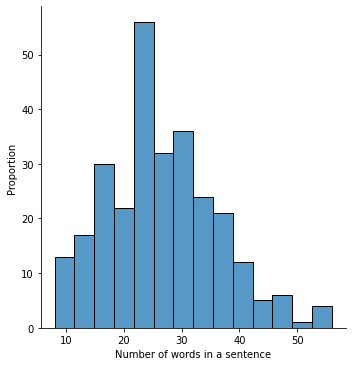

In [ ]:
# Examine sentences length's distribution
lengths = list(map(lambda x: len(x), sentences_data))
sns.displot(lengths)
plt.xlabel("Number of words in a sentence")
plt.ylabel("Proportion")
print("Median: ",np.median(lengths))
print("Mean: ",round(np.mean(lengths),2))

## Machine Learning approach

### 1) Inherit scikit-learn based classes approach
Our initial baseline approach is to inherit BaseEstimator and TransformerMixin classes from scikit-learn. Those classes give the get_params and set_params methods that all Scikit-learn estimators require as well as gives the fit_transform method respectively. Altogether, we want to create a scikit-learn base classes to use with the built-in cross-validation.

In [ ]:
# We construct a plain Python classes and inherit some of scikit-learn classes to implement their functions
# to make a simple memory tagger 
class MemoryTagger(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y):
        # Expects a list of words as X and a list of tags as y.
        voc = {}
        self.tags = []
        for x, t in zip(X, y):
            if t not in self.tags:
                self.tags.append(t)
            if x in voc:
                if t in voc[x]:
                    voc[x][t] += 1
                else:
                    voc[x][t] = 1
            else:
                voc[x] = {t: 1}
        self.memory = {}
        for k, d in voc.items():
            self.memory[k] = max(d, key=d.get)
    
    def predict(self, X, y=None):
        # Predict the the tag from memory. If word is unknown, predict 'O'.
        return [self.memory.get(x, 'O') for x in X]

In [ ]:
tagger = MemoryTagger()

In [ ]:
tagger.fit(total_words, total_tags)

In [ ]:
print(tagger.predict(total_words))

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-DOSAGE', 'O', 'B-DRUG', 'O', 'B-DOSAGE', 'I-DOSAGE', 'I-DOSAGE', 'I-DOSAGE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DRUG', 'O', 'I-DOSAGE', 'I-DOSAGE', 'I-DOSAGE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DRUG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DOSAGE', 'I-DOSAGE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-DOSAGE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DRUG', 'B-DOSAGE', 'O', 'O', 'O', 'O', 'B-DRUG', 'B-DOSAGE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DOSAGE', 'O', 'O', 'B-DRUG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DOSAGE', 'O', 'O', 'B-DRUG', 'O',

In [ ]:
tagger.tags

['O', 'B-DRUG', 'B-DOSAGE', 'I-DOSAGE', 'I-DRUG']

In [ ]:
words = df["Word"].values.tolist()
tags = df["Tag"].values.tolist()

In [ ]:
pred = cross_val_predict(estimator=MemoryTagger(), X=words, y=tags, cv=5)

In [ ]:
report = classification_report(y_pred=pred, y_true=tags)
print(report)

              precision    recall  f1-score   support

    B-DOSAGE       0.72      0.59      0.65       269
      B-DRUG       0.78      0.27      0.40       273
    I-DOSAGE       0.60      0.57      0.58       430
      I-DRUG       0.54      0.28      0.37        53
           O       0.92      0.96      0.94      6343

    accuracy                           0.89      7368
   macro avg       0.71      0.53      0.59      7368
weighted avg       0.89      0.89      0.88      7368



**Evaluation:**
Overall, the precision is quite reasonable but the recall is quite poor.To overcome this issue, we will now introduce a simple machine learning model to predict the named entities. To achieve this, we convert the data to a simple feature vector for every word and then use a random forest to classify the words.


### 2) Using RandomForest model

In [ ]:
# We define simple rules for word feature function
def feature_map(word):
    '''Simple feature map.'''
    return np.array([word.istitle(), word.islower(), word.isupper(), len(word), word.isdigit(), word.isalpha()])

In [ ]:
words = [feature_map(w) for w in df["Word"].values.tolist()]

In [ ]:
# Making prediction on the validation set using RandomForest model with the help of cross-validation techniques to make use
# of our humble-sized dataset
pred = cross_val_predict(RandomForestClassifier(n_estimators=20),
                         X=words, y=tags, cv=5)

In [ ]:
report = classification_report(y_pred=pred, y_true=tags)
print(report)

              precision    recall  f1-score   support

    B-DOSAGE       0.57      0.18      0.27       269
      B-DRUG       0.36      0.03      0.06       273
    I-DOSAGE       0.38      0.02      0.04       430
      I-DRUG       0.00      0.00      0.00        53
           O       0.87      0.99      0.93      6343

    accuracy                           0.86      7368
   macro avg       0.44      0.24      0.26      7368
weighted avg       0.80      0.86      0.81      7368



The ouput is really bad, which is expected as we lack the information of each tag to make decision. To overcome this problem, we decided to employ a more sophisticated model, which is Conditional Random Field - CRF

### 3) Using CRF model

A Conditional Random Field (CRF) is a standard model for predicting the most likely sequence of labels that correspond to a sequence of inputs. It is a supervised learning method which has been proven to be better than the tree based models when it comes to NER. Whereas a discrete classifier predicts a label for a single sample without considering "neighboring" samples, a CRF can take context into account; e.g., the linear chain CRF (which is popular in natural language processing) predicts sequences of labels for sequences of input samples.

In order to use CRF, we will enhance the feature set and create more features which can be used by the model to predict the tags correctly. Also, we add new features such as upper, lower, digit, title etc. for each word and also consider the consecutive words in the list. In short, we try to provide a sequence of features to the model for each word - the sequence containing capitalisations, type of word(title) etc.

In [ ]:
# This function is inherit from sklearn-crfsuite and used to perform feature extraction with a simple baseline features
def word2features(sent, i):
    word = sent[i][0]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        
    }
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
     
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
    
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

def sent2tokens(sent):
    return [token for token, label in sent]

In [ ]:
X = [sent2features(s) for s in sentences_data]
y = [sent2labels(s) for s in sentences_data]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [ ]:
from sklearn_crfsuite import CRF
crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)
crf.fit(X_train, y_train)

In [ ]:
tags = list(crf.classes_)
tags.remove('O')
tags

['B-DRUG', 'I-DRUG', 'B-DOSAGE', 'I-DOSAGE']

In [ ]:
from sklearn_crfsuite import metrics
y_pred = crf.predict(X_val)
metrics.flat_f1_score(y_val, y_pred,
                      average='macro', labels=tags)

0.6641192918689831

In [ ]:
y_pred

[['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-DOSAGE',
  'I-DOSAGE',
  'I-DOSAGE',
  'B-DRUG',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-DRUG',
  'O',
  'O',
  'O',
  'O',
  'B-DOSAGE',
  'I-DOSAGE',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'B-DOSAGE',
  'I-DOSAGE',
  'I-DOSAGE',
  'I-DOSAGE',
  'O',
  'B-DRUG',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'B-DOSAGE',
  'I-DOSAGE',
  'I-DOSAGE',
  'B-DRUG',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-DRUG',
  'B-DOSAGE',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O', 'O', 'O', 'O', 'O', 'B-DOSAGE', 'I-DOSAGE', 'B-DRUG', 'O'],
 ['O',
  'O',


In [ ]:
sorted_tags = sorted(
    tags,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_val, y_pred, labels=sorted_tags, digits=3
))

              precision    recall  f1-score   support

    B-DOSAGE      0.737     0.683     0.709        41
    I-DOSAGE      0.619     0.565     0.591        69
      B-DRUG      0.789     0.682     0.732        44
      I-DRUG      0.833     0.500     0.625        10

   micro avg      0.703     0.622     0.660       164
   macro avg      0.745     0.607     0.664       164
weighted avg      0.707     0.622     0.660       164



In [ ]:
print('model size: {:0.2f}M'.format(crf.size_ / 1000000))

model size: 0.09M


The result is actually noticeable, although the micro-f1 has not fluctuate, other metrics experiecne a noticable rise in figure, particularly those of I-DRUG tag. 

### 4) CRF hyperparameters optimization

In [ ]:
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

In [ ]:
crf_tuned = CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='macro', labels=tags)

# define grid search 
rs = RandomizedSearchCV(crf_tuned, params_space,
                        cv=5,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=True, averaging=None,
                                 c=None, c1=None, c2=None,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None, gamma=None,
                                 keep_...
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7197448550>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7197504410>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,


In [ ]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.058761573113500463, 'c2': 0.008854148643341015}
best CV score: 0.6280446464876833
model size: 0.08M


In [ ]:
crf_tuned = rs.best_estimator_
y_pred = crf_tuned.predict(X_val)
print(metrics.flat_classification_report(
    y_val, y_pred, labels=sorted_tags, digits=3
))

              precision    recall  f1-score   support

    B-DOSAGE      0.757     0.683     0.718        41
    I-DOSAGE      0.641     0.594     0.617        69
      B-DRUG      0.763     0.659     0.707        44
      I-DRUG      1.000     0.500     0.667        10

   micro avg      0.715     0.628     0.669       164
   macro avg      0.790     0.609     0.677       164
weighted avg      0.724     0.628     0.669       164



**Evaluation**: From observation, the tuned-CRF achieved outperform the baseline CRF on macro-f1 score. Moreover, jusdging from other expects, such as model size, Precision and Recall score on each tag, we can notice a slight increase in these metrics from the tuned-CRF. Therefore, within all Machine Learning model, **tuned-CRF** would be the best performance one.

## Deep Learning approach

### Dictionaries of words and tags

Before feeding the data into the deep learning model, we have to preprocess the text.

1. We will use the word2idx dictionary to convert each word to its corresponding ID and the tag2idx to perform the same task for the labels Converting words and present them in integers help reserving more memory.

2. In order to feed the text input into our model (we are experimenting different approaches with the Bi-LSTM-CRF model, we have to make sure all text (sentences) must be in the same length. There are 2 more methods 2 perform this task, one is to declare the batch_size = 1 or you can declare your batch_size > 1 but with all equal-length samples at each batch. However, I choose the Padding technique as it is more elegant and clean.We ensure this using the sequence.pad_sequences() method and MAX_LEN variable. All texts longer than MAX_LEN are truncated and shorter texts are padded to get them to the same length.

In [ ]:
from future.utils import iteritems

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

idx2tag = {v: k for k, v in iteritems(tag2idx)}

### Pad sentences
All the neural networks require to have inputs that have the same shape and size. However, when we pre-process and use the texts as inputs for our model e.g. LSTM, not all the sentences have the same length. In other words, naturally, some of the sentences are longer or shorter. We need to have the inputs with the same size, this is where the padding is necessary.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


max_len = max([len(s) for s in sentences_data])

X = [[word2idx[w[0]] for w in s] for s in sentences_data]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post",value=word2idx["PAD"])

y = [[tag2idx[w[1]] for w in s] for s in sentences_data]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["PAD"])

y = [to_categorical(i, num_classes=n_tags+1) for i in y] #n+1 for PAD

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Modeling

In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, SpatialDropout1D
import keras as k
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#### 1) Bi-LSTM baseline with dropout

In [ ]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words+2, output_dim=50, input_length=max_len)(input)  # 50-dim embedding
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)  # variational biLSTM
out = TimeDistributed(Dense(n_tags+1, activation="softmax"))(model)  # softmax output layer
model = Model(input, out)

In [ ]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics = [keras.metrics.Precision(),
                        keras.metrics.Recall()])

In [ ]:
chkpt = ModelCheckpoint("ner_lstm_baseline_model.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

# Define early stopper to monitor the fluctuation of val_loss, stop the training process if detect no further progression
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=0, mode='min', baseline=None, restore_best_weights=False)

callbacks = [chkpt]

history = model.fit(
    x=X_train,
    y=np.array(y_train),
    validation_split=0.2,
    epochs = 10,
    batch_size = 64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
3/3 [==============================] - 7s 660ms/step - loss: 1.7298 - precision_16: 0.0000e+00 - recall_16: 0.0000e+00 - val_loss: 1.3242 - val_precision_16: 0.0000e+00 - val_recall_16: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.32422, saving model to ner_lstm_baseline_model.h5
Epoch 2/10
3/3 [==============================] - 1s 264ms/step - loss: 1.1585 - precision_16: 0.5380 - recall_16: 0.2286 - val_loss: 0.6589 - val_precision_16: 0.9089 - val_recall_16: 0.7722

Epoch 00002: val_loss improved from 1.32422 to 0.65890, saving model to ner_lstm_baseline_model.h5
Epoch 3/10
3/3 [==============================] - 1s 264ms/step - loss: 0.6195 - precision_16: 0.8956 - recall_16: 0.8052 - val_loss: 0.4924 - val_precision_16: 0.8738 - val_recall_16: 0.8548

Epoch 00003: val_loss improved from 0.65890 to 0.49236, saving model to ner_lstm_baseline_model.h5
Epoch 4/10
3/3 [==============================] - 1s 263ms/step - loss: 0.5052 - precision_16: 0.8706 - recall_1

In [ ]:
pred_cat = model.predict(X_test)
pred = np.argmax(pred_cat, axis=-1)
y_test_true = np.argmax(y_test, -1)

In [ ]:
from sklearn_crfsuite.metrics import flat_classification_report

# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_test_true_tag = [[idx2tag[i] for i in row] for row in y_test_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_test_true_tag)
print(report)

              precision    recall  f1-score   support

    B-DOSAGE       0.00      0.00      0.00        53
      B-DRUG       0.00      0.00      0.00        54
    I-DOSAGE       0.00      0.00      0.00        88
      I-DRUG       0.00      0.00      0.00        14
           O       0.77      0.99      0.87      1268
         PAD       0.99      0.90      0.94      1659

    accuracy                           0.88      3136
   macro avg       0.29      0.31      0.30      3136
weighted avg       0.84      0.88      0.85      3136



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



The result is extremely devastating as the model could not recognize any DRUG or DOSAGE tags correctly. The macro-f1 score is disappointing. The main reason in charge for this result is the the overwhelming biased between tag categories. 

#### 2) Bi-LSTM + LSTM with dropout
In order to tackle the above issue, we add more layer, particularly LSTM layer to increase the model learning capability, to capture more information from the context

In [ ]:
input = Input(shape=(max_len,))

#Increase word_embedding_size: 
word_embedding_size = 100

# Embedding Layer
model_2 = Embedding(input_dim=n_words+2, output_dim=word_embedding_size, input_length=max_len)(input)

# BI-LSTM Layer
model_2 = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=k.initializers.he_normal()))(model_2)
model_2 = LSTM(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(model_2)

# TimeDistributed Layer
out = TimeDistributed(Dense(n_tags+1, activation="softmax"))(model_2)  

# out = crf(model)  # output
model_2 = Model(input, out)

In [ ]:
#Optimiser 
adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

# Compile model
model_2.compile(optimizer=adam, loss='categorical_crossentropy', 
                metrics=[keras.metrics.Precision(),
                        keras.metrics.Recall()])

model_2.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 56)]              0         
_________________________________________________________________
embedding_27 (Embedding)     (None, 56, 100)           158100    
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 56, 200)           160800    
_________________________________________________________________
lstm_38 (LSTM)               (None, 56, 200)           320800    
_________________________________________________________________
time_distributed_27 (TimeDis (None, 56, 6)             1206      
Total params: 640,906
Trainable params: 640,906
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Saving the best model only
filepath="ner_stacked_bi_lstm_model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# Fit the best model
history = model_2.fit(X_train, np.array(y_train), batch_size=128, epochs=20, validation_split=0.2, verbose=1, callbacks=callbacks_list)

Epoch 1/20
2/2 [==============================] - 12s 2s/step - loss: 1.7731 - precision_18: 0.0000e+00 - recall_18: 0.0000e+00 - val_loss: 1.5879 - val_precision_18: 0.0000e+00 - val_recall_18: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.58794, saving model to ner_stacked_bi_lstm_model.hdf5
Epoch 2/20
2/2 [==============================] - 2s 774ms/step - loss: 1.5896 - precision_18: 0.0000e+00 - recall_18: 0.0000e+00 - val_loss: 1.3640 - val_precision_18: 0.0000e+00 - val_recall_18: 0.0000e+00

Epoch 00002: val_loss improved from 1.58794 to 1.36402, saving model to ner_stacked_bi_lstm_model.hdf5
Epoch 3/20
2/2 [==============================] - 2s 767ms/step - loss: 1.3837 - precision_18: 0.6667 - recall_18: 0.0146 - val_loss: 1.1042 - val_precision_18: 1.0000 - val_recall_18: 0.4218

Epoch 00003: val_loss improved from 1.36402 to 1.10424, saving model to ner_stacked_bi_lstm_model.hdf5
Epoch 4/20
2/2 [==============================] - 2s 748ms/step - loss: 1.1531 - preci

In [ ]:
pred_cat = model_2.predict(X_test)
pred = np.argmax(pred_cat, axis=-1)
y_test_true = np.argmax(y_test, -1)

In [ ]:
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_test_true_tag = [[idx2tag[i] for i in row] for row in y_test_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_test_true_tag)
print(report)

              precision    recall  f1-score   support

    B-DOSAGE       0.00      0.00      0.00        53
      B-DRUG       0.00      0.00      0.00        54
    I-DOSAGE       0.00      0.00      0.00        88
      I-DRUG       0.00      0.00      0.00        14
           O       0.85      0.95      0.90      1268
         PAD       0.96      1.00      0.98      1659

    accuracy                           0.91      3136
   macro avg       0.30      0.33      0.31      3136
weighted avg       0.86      0.91      0.88      3136



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



The result is not improving at all, although there is a slight increase in macro f1, from 0.3 to 0.31. However, others metrics from all tags remain unchanged, which mean the model is not sufficent enough to capture those information.

## Ultimate Judgement
Based on the performance of each approaches towards the chosen metrics - macro-f1 score. We finally came to the conclusion that the tuned-CRF is the best model to perform the named entity recognition task on the *Ade_corpus_v2_drug_dosage_relation* dataset. The model itself acquire 65,8% on macro-f1, which is not the best figure comparing to other state-of-the-art solution in the industry.

However, since our dataset structure is not containing any POS-tag for each word, so it may have a noticeable affect on the learning capability of the CRF model. Because POS-tag concerns about the context information in a sentence, it might help CRF preserve more information rather than just remembering the word itself. For futreu improvement, we definitely need to construct and expand our dataset in order to increase the model performance.

## Best model export and testing

In [ ]:
model_path = '/content/drive/MyDrive/ML_A2/ner-model'

In [ ]:
import pickle
# save the model to disk
pickle.dump(crf_tuned, open(model_path, 'wb')) 

In [ ]:
# load the model from disk
ner_model = pickle.load(open(model_path, 'rb'))

In [ ]:
# Our NER model information
ner_model

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.058761573113500463, c2=0.008854148643341015,
    calibration_candidates=None, calibration_eta=None,
    calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/ML_A2/data-testing-ner')
test

,Unnamed: 0,text,label
0,0,A prerenal component could have contributed to...,1
1,3,Hypersensitivity to zonizamide has been confir...,1
2,4,The three reported cases demonstrate that trog...,1
3,5,Epstein Bar virus-related lymphocyte prolifera...,1
4,10,Methotrexate is an effective but potentially t...,1
...,...,...,...
3461,6651,Fulminating hepatic failure developed in a 24-...,1
3462,6654,"He has developed recurring skin rash, fever, h...",1
3463,6655,Hyperammonia induced by carbamazepine.,1
3464,6656,Atypical endometriosis may act as a precancero...,1


In [ ]:
# Define a customize word2feature function to test
def word2features_cus(sent, i):
    word = sent[i]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        
    }
    if i > 0:
        word1 = sent[i-1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
     
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1]
    
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True

    return features

def sent2features_cus(sent):
    return [word2features_cus(sent, i) for i in range(len(sent))]

In [ ]:
# For the purpose of the testing, we only make prediction on the first 5 sentences of the testing dataset
sent_list = test['text'].sample(10).tolist()
sent_list

['Eboprofen rarely causes adverse reactions of gastrointestinal tract, but is involved in systemic and local side effects in lupus patients.',
 'To our knowledge, this recurrence of amiodarone pulmonary toxicity has not been previously informed.',
 'We describe the development of cutaneous scleroderm in 3 patients coinciding with the use of low cumulative low dose bleomycin less than 100 U.',
 'Only few reports exist on iodine-induced hypothyroidism after a single injection of the iodized radiopaque dye Lipiodol.',
 'A fatal case of theophylline intoxication.',
 'Meeting of granulocytosis, eosinophilic, skin reaction and hepatitis, has been reported in Propylthiova (PTU) therapy for tyrotoxycycles in black women aged 47.',
 'As a result, Amantadine has been permanently disturbed and the cornea has renewed again.',
 'The most likely cause of hepatic insufficiency in this patient was, therefore, clarithromycin, which is subjected to a hepatic metabolism and has been reported that it caus

In [ ]:
# Segmentate a sentence into sequence of words and create a list to store all of those sequences
sent = []
for s in sent_list:
  tmp = s.split()
  sent.append(tmp)
sent

[['Eboprofen',
  'rarely',
  'causes',
  'adverse',
  'reactions',
  'of',
  'gastrointestinal',
  'tract,',
  'but',
  'is',
  'involved',
  'in',
  'systemic',
  'and',
  'local',
  'side',
  'effects',
  'in',
  'lupus',
  'patients.'],
 ['To',
  'our',
  'knowledge,',
  'this',
  'recurrence',
  'of',
  'amiodarone',
  'pulmonary',
  'toxicity',
  'has',
  'not',
  'been',
  'previously',
  'informed.'],
 ['We',
  'describe',
  'the',
  'development',
  'of',
  'cutaneous',
  'scleroderm',
  'in',
  '3',
  'patients',
  'coinciding',
  'with',
  'the',
  'use',
  'of',
  'low',
  'cumulative',
  'low',
  'dose',
  'bleomycin',
  'less',
  'than',
  '100',
  'U.'],
 ['Only',
  'few',
  'reports',
  'exist',
  'on',
  'iodine-induced',
  'hypothyroidism',
  'after',
  'a',
  'single',
  'injection',
  'of',
  'the',
  'iodized',
  'radiopaque',
  'dye',
  'Lipiodol.'],
 ['A', 'fatal', 'case', 'of', 'theophylline', 'intoxication.'],
 ['Meeting',
  'of',
  'granulocytosis,',
  'eosinop

In [ ]:
X_test = [sent2features_cus(s) for s in sent]

In [ ]:
X_test

[[{'+1:word.istitle()': False,
   '+1:word.isupper()': False,
   '+1:word.lower()': 'rarely',
   'BOS': True,
   'bias': 1.0,
   'word.isdigit()': False,
   'word.istitle()': True,
   'word.isupper()': False,
   'word.lower()': 'eboprofen',
   'word[-2:]': 'en',
   'word[-3:]': 'fen'},
  {'+1:word.istitle()': False,
   '+1:word.isupper()': False,
   '+1:word.lower()': 'causes',
   '-1:word.istitle()': True,
   '-1:word.isupper()': False,
   '-1:word.lower()': 'eboprofen',
   'bias': 1.0,
   'word.isdigit()': False,
   'word.istitle()': False,
   'word.isupper()': False,
   'word.lower()': 'rarely',
   'word[-2:]': 'ly',
   'word[-3:]': 'ely'},
  {'+1:word.istitle()': False,
   '+1:word.isupper()': False,
   '+1:word.lower()': 'adverse',
   '-1:word.istitle()': False,
   '-1:word.isupper()': False,
   '-1:word.lower()': 'rarely',
   'bias': 1.0,
   'word.isdigit()': False,
   'word.istitle()': False,
   'word.isupper()': False,
   'word.lower()': 'causes',
   'word[-2:]': 'es',
   'word

In [ ]:
predictions = ner_model.predict(X_test)

In [ ]:
# Final prediction of our model on the list of 10 sample sentences
predictions

[['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'B-DRUG', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-DOSAGE',
  'O',
  'B-DRUG',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O', 'O', 'O', 'O', 'B-DRUG', 'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['

**Evaluation:**
From the above result, it seems that our model can recognize a proportion of word and classify those words with the corresponding tag. However, since the model performance is not that sufficient, false-tagging and missing information is inevitable, but we can improve this model if we can define more complex feature extracion rules, tuning our CRF model with more hyperparameter or collect more data.